# May ??th, 2022 (cast votes)

**Motivation**: Make group plots (KABA) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def quick_show(
    data,
    vmin=0.1,
    vmax=None,
    figsize=None,
    cmap='magma',
    ylabel_fontsize=11.5,
    show: bool = True, ):
    num = max(len(tr['proj-top']) for tr in data.values())
    figsize = figsize if figsize else (13.5, 1.6 * len(data))
    fig, axes = create_figure(
        nrows=len(data),
        ncols=num,
        figsize=figsize,
        tight_layout=False,
        constrained_layout=False,
        reshape=True,
    )
    for i, (lbl, tr) in enumerate(data.items()):
        for j in range(num):
            ax = axes[i, j]
            if j >= len(tr['proj-top']):
                ax.remove()
            else:
                ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
                if np.nanmax(tr['proj-top'][j]) > 1:
                    _cmap = get_cluster_cmap(range(len(tr['proj-top']) - 1))
                    _vmax = None
                else:
                    _cmap = cmap
                    _vmax = vmax
                ax.imshow(
                    mwh(tr['proj-top'][j] < vmin, tr['proj-top'][j]),
                    cmap=_cmap, vmin=vmin, vmax=_vmax,
                )
                if j == 0:
                    ax.set_ylabel(lbl, fontsize=ylabel_fontsize)
    remove_ticks(axes)
    if show:
        plt.show()
    else:
        plt.close()
    return fig, axes


## Fig dir

In [3]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [7]:
mice = Mice(128)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

## task = 'rest', k = 6, p = 10

In [5]:
task = 'rest'
band_ca = (0.01, 0.5)
mice.setup_func_data(task, band_ca=band_ca)

num_k, p = 6, 10
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [8]:
#gr_bo = Group(**props_bo).fit_group()
#gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(
#    gr_bo.run_pi, 3), 2), 1), 0)

gr_ca = Group(**props_ca).fit_group()
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(
    gr_ca.run_pi, 3), 2), 1), 0)

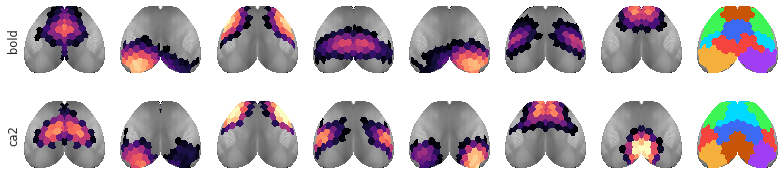

In [7]:
d2p = {
    'bold': gr_bo.trim2d(gr_bo.project_vec()),
    'ca2': gr_ca.trim2d(gr_ca.project_vec()),
}
_ = quick_show(d2p, vmin=0.1, vmax=0.8)

In [8]:
n_runs = collections.defaultdict(int)
for key in gr_bo.address:
    sub, ses, run = mice.looper[key]
    n_runs[mice.get_key(sub)] += 1
n_runs = dict(n_runs)
n_runs

{
    'sub-SLC01': 12,
    'sub-SLC02': 11,
    'sub-SLC03': 11,
    'sub-SLC04': 12,
    'sub-SLC05': 11,
    'sub-SLC06': 12,
    'sub-SLC07': 11,
    'sub-SLC08': 11,
    'sub-SLC09': 12,
    'sub-SLC10': 11
}

In [9]:
n_runs = collections.defaultdict(int)
for key in gr_ca.address:
    sub, ses, run = mice.looper[key]
    n_runs[mice.get_key(sub)] += 1
n_runs = dict(n_runs)
n_runs

{
    'sub-SLC01': 12,
    'sub-SLC02': 10,
    'sub-SLC03': 10,
    'sub-SLC04': 10,
    'sub-SLC05': 10,
    'sub-SLC06': 12,
    'sub-SLC07': 11,
    'sub-SLC08': 11,
    'sub-SLC09': 12,
    'sub-SLC10': 12
}

In [36]:
pr_ci = 0.95
pr_thres = 0.01
# pruned_bo = gr_bo.prune(thres=pr_thres, ci=pr_ci)
pruned_ca = gr_ca.prune(thres=pr_thres, ci=pr_ci)

[PROGRESS] 'se_indiv-pi_1.0e+04.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/results/SVINET/Gro
up/real_pearson_ca2_rest_bp(0.01,0.5)_k6_p10-sample

In [37]:
terrible = pruned_ca['votes']['votes'].sum(-1) == pruned_ca['votes']['votes'].shape[-1]
terr_nodes = np.where(terrible)[0]
len(set(terr_nodes))

21

76

31

<AxesSubplot:ylabel='Count'>

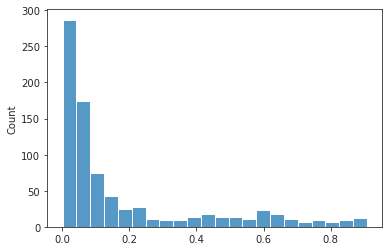

In [38]:
sns.histplot(pruned_ca['pi_prune_avg'][pruned_ca['pi_prune_avg'].nonzero()])

<AxesSubplot:ylabel='Count'>

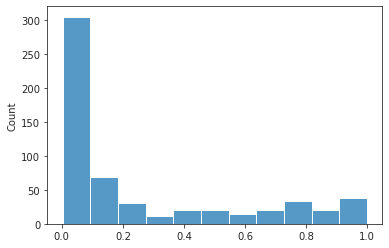

<AxesSubplot:ylabel='Count'>

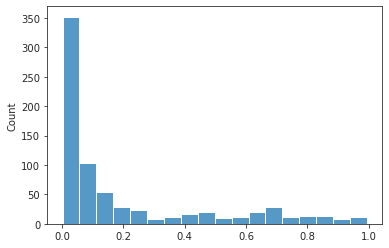

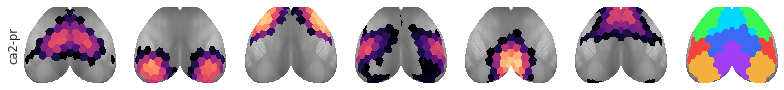

In [39]:
d2p = {
    #'bold-pr': gr_bo.trim2d(gr_bo.project_vec(pruned_bo['pi_prune_avg'])),
    #**d2p,
    'ca2-pr': gr_ca.trim2d(gr_ca.project_vec(pruned_ca['pi_prune_avg'])),
}
_ = quick_show(d2p, vmin=0.1, vmax=1.0)

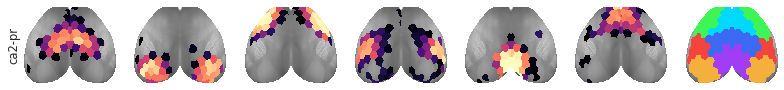

In [40]:
_, colors = get_cluster_cmap(range(6), return_colors=True)

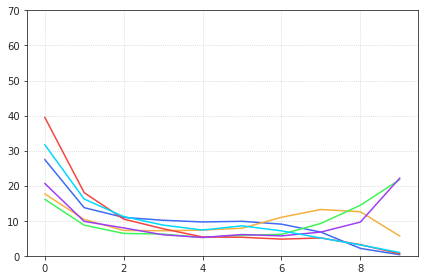

In [41]:
fig, ax = create_figure()
for i, c in enumerate(colors):
    ax.plot(pruned_ca['cut_prune_avg'][i], color=c)
ax.set_ylim(0, 70)
ax.grid()
plt.show()

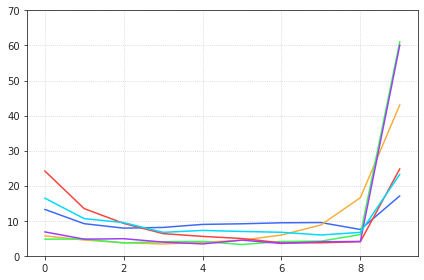

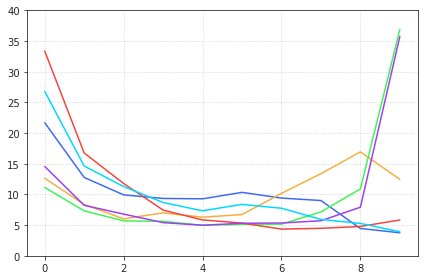

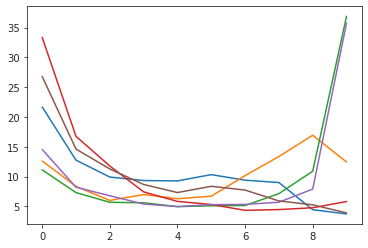

In [14]:
plt.plot(pruned_ca['cut_prune_avg'].T);

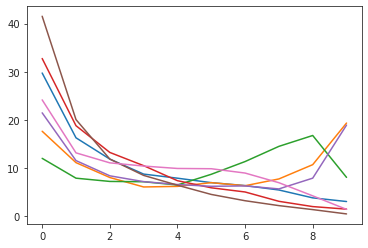

In [18]:
plt.plot(pruned_bo['cut_prune_avg'].T);

In [36]:
np.linspace(0.1, 1.0, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [41]:
np.linspace(0.1, 1.0, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [9]:
pi = bn.nanmean(gr_bo.run_pi, -3)
i, j, k, kk, nn = pi.shape
dims = {'sub': i, 'ses': j, 'run': k}

In [11]:
b_anim = bootstrap(
    x=pi,
    n_resamples=int(1e3),
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim.shape

(1000, 10, 3, 4, 7, 152)

In [12]:
b_anim = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim, axis=0, ddof=1)
se_anim.shape

(10, 7, 152)

In [13]:
votes_dict = gr_bo.cast_votes(se_anim, pi, 0.01, 0.99)
votes_dict['votes'].sum(), np.prod(votes_dict['votes'].shape)

(5347.0, 10640)

In [14]:
votes_dict['votes'].shape

(152, 10, 7)

In [26]:
terrible = votes_dict['votes'].sum(-1) == votes_dict['votes'].shape[-1]
np.where(terrible)

(array([ 44,  74, 146]), array([5, 6, 0]))

In [27]:
pi_prune = pi.copy()
for node in range(nn):
    for anim in range(i):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, j, axis=0)
        vote = np.repeat(vote, k, axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_anim = bn.nanmean(bn.nanmean(pi_prune, 2), 1)
pi_prune_grp = bn.nanmean(pi_prune_anim, 0)

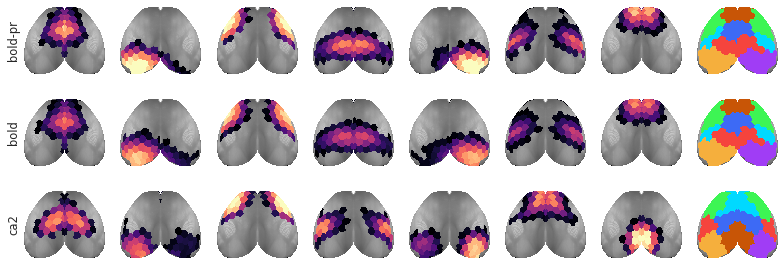

In [28]:
d2p = {
    'bold-pr': gr_bo.trim2d(gr_bo.project_vec(pi_prune_grp)),
    **d2p
}
_ = quick_show(d2p, vmin=0.1, vmax=0.8)

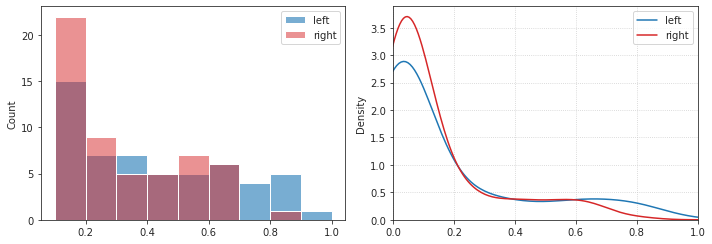

In [35]:
fig, axes = create_figure(1, 2, (10, 3.5))
# sns.histplot(pi_prune[9, 2, 3][1], bins=np.linspace(0, 1, 11), color='dimgrey', label='mg', ax=axes[0])
sns.histplot(pi_prune[9, 2, 3][1], bins=np.linspace(0.1, 1, 10), color='C0', label='left', alpha=0.6, ax=axes[0])
sns.histplot(pi_prune[9, 2, 3][4], bins=np.linspace(0.1, 1, 10), color='C3', label='right', alpha=0.5, ax=axes[0])
axes[0].legend()

# sns.kdeplot(pi_prune_mg[9, 2, 3][1], color='k', label='mg', ax=axes[1])
sns.kdeplot(pi_prune[9, 2, 3][1], color='C0', label='left', ax=axes[1])
sns.kdeplot(pi_prune[9, 2, 3][4], color='C3', label='right', ax=axes[1])
axes[1].set_xlim(0, 1)
axes[1].legend()
axes[1].grid()
plt.show()

In [34]:
pi[9, 2, 3][1]

array([0.06109028,        nan, 0.3290447 , 0.00757359, 0.05594796,
       0.03989959, 0.01012342, 0.10128485, 0.03562574, 0.01127678,
       0.15710124, 0.05489677, 0.02597   , 0.07438252, 0.04519766,
       0.00492137, 0.00434628, 0.03552658, 0.04497435, 0.02412376,
       0.02909609, 0.01532808, 0.03465596, 0.00558511, 0.01322815,
       0.12662222, 0.1278274 , 0.03980393, 0.02101334, 0.04870197,
       0.01676489, 0.15906268, 0.10731806, 0.05521774, 0.12289104,
       0.03175582, 0.02964389, 0.01687234, 0.14475659, 0.08549214,
       0.05243889, 0.08555145, 0.0608389 , 0.03233968, 0.12491212,
       0.06935052, 0.13111827, 0.13985348, 0.11632289, 0.11627378,
       0.09288428, 0.04669715, 0.37563932, 0.63916439, 0.07532696,
       0.11540172, 0.34507771, 0.37053558, 0.08422235, 0.81221219,
       0.23842879, 0.19471186, 0.49891672, 0.50859351, 0.63261031,
       0.75266203, 0.23412058, 0.63881309, 0.36618734, 0.70834873,
       0.7939761 , 0.73586143, 0.73690881, 0.76370054, 0.6586398 ,
       0.67568486, 0.04389784, 0.0678573 , 0.07099221, 0.03633535,
       0.04468407, 0.03908359, 0.02702271, 0.0536561 , 0.03882336,
       0.11633805, 0.00707695, 0.04252065, 0.01083256, 0.00629147,
       0.05897918, 0.00558638, 0.01353694, 0.14004701, 0.0411191 ,
       0.08967132, 0.01799624, 0.01570302, 0.06005594, 0.00645643,
       0.01924878, 0.17877597, 0.02310515, 0.01158539, 0.00715266,
       0.00632669, 0.01737611, 0.05662972, 0.02418758, 0.0127874 ,
       0.0246825 , 0.01008612, 0.0345346 , 0.0113685 , 0.03767291,
       0.04133084, 0.01959908, 0.0184249 , 0.03471876, 0.02379337,
       0.20143843, 0.07394484, 0.08799832, 0.02771715, 0.02112157,
       0.02334725, 0.02628021, 0.06481629, 0.30930145, 0.03032704,
       0.31906874, 0.03261071, 0.02458434, 0.02344863, 0.12452276,
       0.03963965, 0.46394158, 0.63195784, 0.05758363, 0.07818641,
       0.23763222, 0.14491894, 0.23464857, 0.57663725, 0.3003573 ,
       0.45142923, 0.54092616, 0.4616599 , 0.61096502, 0.41962964,
       0.66454636, 0.32601381])

[<matplotlib.lines.Line2D object at 0x7fade28fd3d0>]

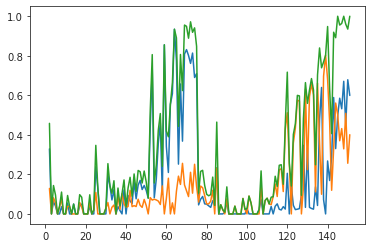

In [38]:
plt.plot(pi_prune[9, 2, 3][1])
plt.plot(pi_prune[9, 2, 3][4])
plt.plot(pi_prune[9, 2, 3][1] + pi_prune[9, 2, 3][4])

[<matplotlib.lines.Line2D object at 0x7fadc746d220>]

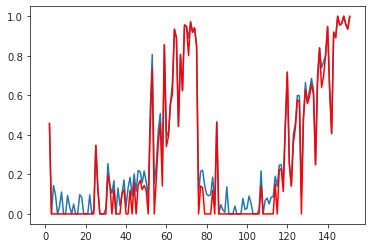

In [54]:
aa = pi_prune[9, 2, 3][1].copy()
bb = pi_prune[9, 2, 3][4].copy()
plt.plot(aa + bb)

aa[aa < 0.1] = 0
bb[bb < 0.1] = 0
plt.plot(aa + bb, color='r')

<AxesSubplot:ylabel='Count'>

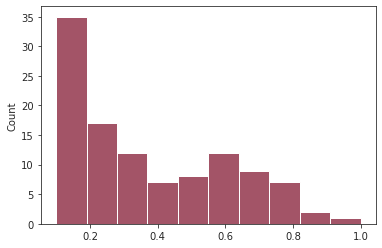

In [55]:
sns.histplot(list(pi_prune[9, 2, 3][1]) + list(pi_prune[9, 2, 3][4]), bins=np.linspace(0.1, 1.0, 11))
sns.histplot(list(aa) + list(bb), bins=np.linspace(0.1, 1.0, 11), color='C3', alpha=0.6)

In [56]:
h = sp_stats.entropy(pi_prune, axis=-2) / np.log(7)
h.shape

(10, 3, 4, 152)

<AxesSubplot:ylabel='Count'>

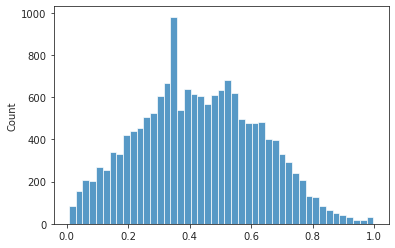

In [61]:
sns.histplot(h[h.nonzero()])

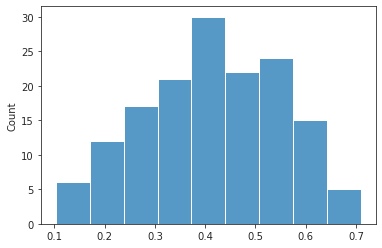

In [62]:
h_avg = bn.nanmean(bn.nanmean(bn.nanmean(h, 2), 1), 0)
sns.histplot(h_avg);

In [63]:
tr = gr_bo.project_vec(h_avg, add_disjoint=False)
tr = gr_bo.trim2d(tr)

<matplotlib.image.AxesImage object at 0x7fade1298a30>

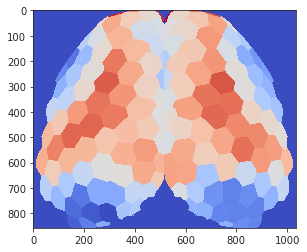

In [67]:
plt.imshow(tr['proj-top'][0], cmap='coolwarm', vmin=np.min(h_avg), vmax=np.max(h_avg))

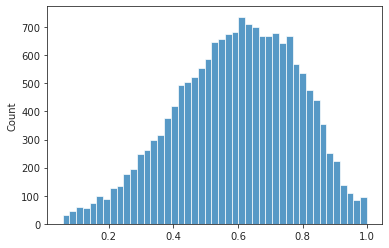

In [68]:
h = sp_stats.entropy(pi, axis=-2) / np.log(7)
sns.histplot(h[h.nonzero()]);

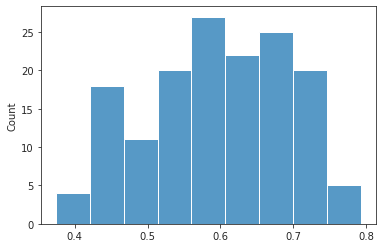

In [69]:
h_avg = bn.nanmean(bn.nanmean(bn.nanmean(h, 2), 1), 0)
sns.histplot(h_avg);

In [70]:
tr_main = gr_bo.project_vec(h_avg, add_disjoint=False)
tr_main = gr_bo.trim2d(tr_main)

<matplotlib.image.AxesImage object at 0x7fade13abc70>

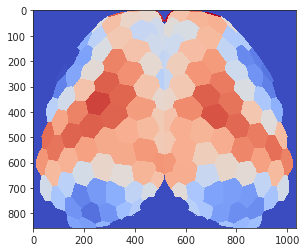

In [71]:
plt.imshow(
    tr_main['proj-top'][0],
    cmap='coolwarm',
    vmin=np.min(h_avg),
    vmax=np.max(h_avg),
)

In [72]:
gr_bo.run_pi.ndim

6

In [76]:
nn, i, j * k

(152, 10, 12)

In [74]:
pi_run = bn.nanmean(gr_bo.run_pi, -3)
pi_anim = bn.nanmean(bn.nanmean(pi_run, 2), 1)
pi_anim.shape

(10, 7, 152)

In [77]:
looper = itertools.product(range(nn), range(i))
for node, anim in looper:
    n_missing = pi_run[anim].reshape(-1, kk, nn)
    n_missing = np.isnan(n_missing).mean(1).mean(1)
    n_missing = (n_missing == 1).sum()
    print(anim, n_missing)

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1

0 0

1 1

2 1

3 0

4 1

5 0

6 1

7 1

8 0

9 1